In [4]:
import torch
from torch.utils.data import Dataset
from xml.etree import ElementTree as ET
import os
from PIL import Image
import matplotlib.pyplot as plt
from typing import Dict
import numpy as np

In [6]:
datadir = '/Users/tiendzung/Downloads/ibug_300W_large_face_landmark_dataset1'
xml_path = os.path.join(datadir,'labels_ibug_300W_train.xml')
root = ET.parse(xml_path).getroot()

In [7]:
samples = root.find('images')

(68, 2)


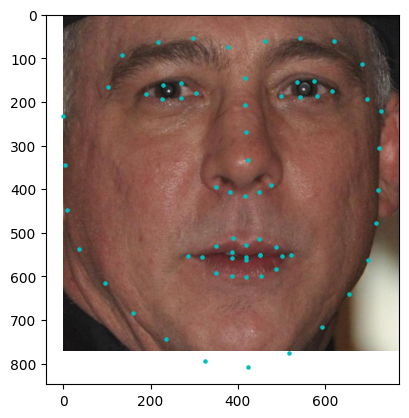

In [8]:
def get_cropped_labeled_sample(sample: ET.Element) -> Dict:
    filename = sample.attrib['file']
    width = int(sample.attrib['width'])
    height = int(sample.attrib['height'])
    
    box = sample.find('box')
    box_top = int(box.attrib['top'])
    box_left = int(box.attrib['left'])
    box_width = int(box.attrib['width'])
    box_height = int(box.attrib['height'])
    
    landmarks = np.array([
        [float(part.attrib['x']), float(part.attrib['y'])] for part in box
    ])
    landmarks -= np.array([box_left, box_top]) # crop
    landmarks /= np.array([box_width, box_height])
    landmarks -= 0.5
        
    return dict(
        filename=filename, width=width, height=height,
        box_top=box_top, box_left=box_left, box_width=box_width, box_height=box_height, 
        landmarks=landmarks,
        # original_image=original_image, cropped_image=cropped_image,
    )

def show_sample(datadir, sample: Dict):
    filename = sample['filename']
    box_top: int = sample['box_top']
    box_left: int = sample['box_left']
    box_width: int = sample['box_width']
    box_height: int = sample['box_height']    
    landmarks: np.ndarray = (sample['landmarks'] + 0.5) * np.array([box_width, box_height])
    original_image: Image = Image.open( os.path.join(datadir, filename) )
    cropped_image: Image = original_image.crop((box_left, box_top, box_left+box_width, box_top+box_height))
    
    plt.imshow(cropped_image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=5, c='c')
    print(landmarks.shape)

for i, sample in enumerate(samples):
    sample = get_cropped_labeled_sample(sample)
    # print(sample) #, landmarks)
    if i == 2000: break
show_sample(datadir, sample)

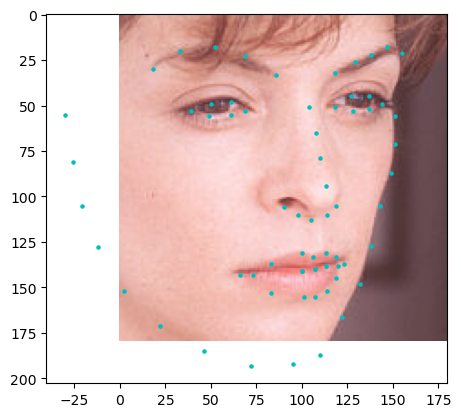

In [2]:
import os
import cv2
cap= cv2.VideoCapture('/Users/tiendzung/Downloads/Duong2.mp4')
i=0
while(cap.isOpened()):
    success, frame = cap.read()
    if success == False:
        break
    cv2.imwrite('/Users/tiendzung/Downloads/facial_landmarks-wandb/data/video/duong'+str(i)+'.jpg',frame)
    i+=1

In [2]:
import cv2
import os
from facenet_pytorch import MTCNN
import torch
from PIL import Image, ImageDraw
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2
import pyrootutils

__file__ = '/Users/tiendzung/Downloads/facial_landmarks-wandb/notebooks/explore_dlib.ipynb'
path = pyrootutils.find_root(
    search_from=__file__, indicator=".project-root")
config_path = str(path / "configs" / "model")
output_path = path / "outputs"
pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)



device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
mtcnn = MTCNN(thresholds= [0.7, 0.7, 0.8] ,keep_all=True, device = device)

transform = Compose([
                A.Resize(224, 224),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])

/Users/tiendzung/opt/anaconda3/envs/facial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [3]:
from src.models.components.simple_resnet import SimpleResnet
from src.models.dlib_module import DlibLitModule

net = SimpleResnet()
# print(net)
model = DlibLitModule.load_from_checkpoint(checkpoint_path='/Users/tiendzung/Downloads/checkpoints/epoch_095.ckpt', net = net)
print(model)

DlibLitModule(
  (net): SimpleResnet(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [4]:
filter = cv2.imread('/Users/tiendzung/Downloads/facial_landmarks-wandb/filter/hat.png')
print(filter.shape[0])

1261


In [5]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,480)
while cap.isOpened():
    isSuccess, frame = cap.read()
    filter = cv2.imread('/Users/tiendzung/Downloads/facial_landmarks-wandb/filter/hat.png')
    if isSuccess:
        boxes, _ = mtcnn.detect(frame)
        faces = mtcnn(frame)
        if boxes is not None:
            face_box = []
            for box in boxes:
                bbox = list(map(int,box.tolist()))
                face_box.append(bbox)
                frame = cv2.rectangle(frame,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,0,255),3)

            for j, face in enumerate(faces):
                face = face.permute(1, 2, 0).numpy()*255
                h = face_box[j][3] - face_box[j][1]
                w = face_box[j][2] - face_box[j][0]
                landmarks = model.forward(transform(image = face)["image"].unsqueeze(0))[0]
                landmarks = (landmarks + 0.5) * torch.Tensor([w, h])
                for i in range (landmarks.shape[0]):
                    frame = cv2.circle(frame, (int(landmarks[i, 0] + face_box[j][0]),int(landmarks[i, 1] + face_box[j][1])), radius=1, color=(255, 255, 0), thickness= 1)
                scale = (face_box[j][2] - face_box[j][0])/(filter.shape[1]*0.55) *0.5
                dim = (int(filter.shape[1]*scale),int(filter.shape[0]*scale))
                f_filter =  cv2.resize(filter, dim, interpolation = cv2.INTER_AREA)
                # print(frame.shape)
                # print(f_filter.shape)
                # print(face_box[j][0], face_box[j][0] + f_filter.shape[0])
                # print(face_box[j][1], face_box[j][1] + f_filter.shape[1])

                frame[face_box[j][1]:face_box[j][1] + f_filter.shape[0], face_box[j][0]:face_box[j][0] + f_filter.shape[1],:] = f_filter
                if cv2.waitKey(1)&0xFF == ord('q'):
                    print(f_filter.max())

    cv2.imshow('Face Detection', frame)
    if cv2.waitKey(1)&0xFF == 27:
        print("YES")
        break
    
cap.release()
cv2.destroyAllWindows()
for i in range(30):
    cv2.waitKey(1)

KeyboardInterrupt: 

: 

In [7]:
cv2.startWindowThread()
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,480)
while cap.isOpened():
    isSuccess, frame = cap.read()
    if isSuccess:
        boxes, _ = mtcnn.detect(frame)
        if boxes is not None:
            for box in boxes:
                bbox = list(map(int,box.tolist()))
                frame = cv2.rectangle(frame,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,0,255),6)
    cv2.imshow('Face Detection', frame)
    if cv2.waitKey(1)&0xFF == 27:
        print("YES")
        # cv2.destroyAllWindows()
        break
    
cap.release()
cv2.destroyAllWindows()
for i in range(30):
    cv2.waitKey(1)

YES


In [1]:
import cv2
import mediapipe as mp
import os
import numpy as np
from matplotlib import pyplot as plt
from imutils import face_utils, rotate_bound


2023-05-02 20:12:22.153968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(179, 513, 4)


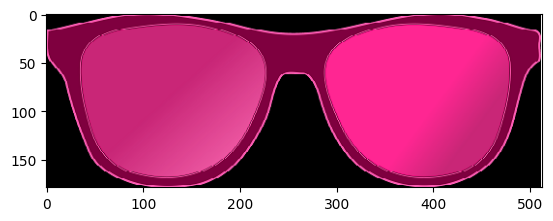

In [50]:
filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 
           'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png', 
           'images/santa_filter.png', 'images/hat.png', 'images/hat2.png',
           'images/glasses.png', 'images/glasses1.png']

for i in range(len(filters)):
    filters[i] = os.path.join('/Users/tiendzung/Downloads/facial_landmarks-wandb', filters[i])
filterIndex = 5
sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
print(sunglasses.shape)
plt.imshow(sunglasses)

(179, 513, 4)


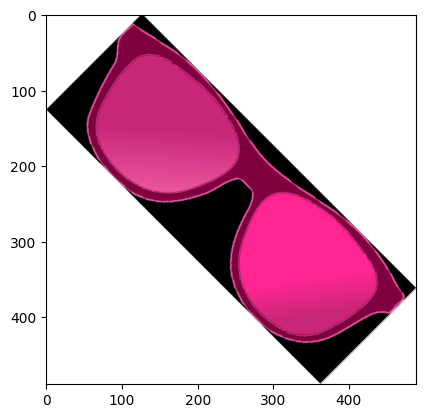

In [51]:
print(sunglasses.shape)
sunglasses = rotate_bound(sunglasses, 45)
plt.imshow(sunglasses)

In [27]:
a = np.array([1, 2, 3, 4])
b = [True, False, True, False]
print(a[b])

[1 3]
